[Cleaning](clean.ipynb)

# EDA

Import and define some functions

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from os.path import exists
import matplotlib.pyplot as plt
from IPython.display import display, Markdown

sns.set_theme(style='darkgrid')

df = pd.read_csv('data/clean.csv')
y = df.mpg

def show_plots(filenames):
    for j in range(0,len(filenames),2):
        if (len(filenames)-j)>1:
            display(Markdown(f'![]({filenames[j]})![]({filenames[j+1]})'))
        else:
            display(Markdown(f'![]({filenames[j]})'))

def make_plots(df, y):
    filenames = []
    
    for col in df.columns:
        filename = 'img/%s_joint.png' % col
        filenames.append(filename)
        if not exists(filename):
            sns.jointplot(x=df[col],y=y,kind='reg',
                          joint_kws={'scatter_kws':dict(alpha=0.3)})
            plt.suptitle(f'{col} vs mpg')
            plt.subplots_adjust(top=.93)
            plt.savefig(filename,facecolor='white',transparent=False)
            plt.close()
        
    show_plots(filenames)

## A bit on engines:

* A most basic description of an engine is that it's an air pump
* Horsepower = (Torque * RPM) / 5252
* Torque peak is where an engine is operating most efficiently as far as air flow, applied science in action. (Fluid dynamics, resonance)
* Operating above or below the torque peak reduces efficiency and efficiency == fuel economy
* Torque peaks normally occur below 5252rpm, and horsepower peaks above that, so long as the engine can actually rev that high. On a dyno sheet (measuring torque and horsepower vs rpm) you'll see the torque/horsepower lines cross at 5252rpm
* As an engine spins faster, the power output increases until combustion is so inefficient and it produces so little torque that spinning faster produces no more power, if it holds together that long

Basically an engine that makes lots of power at high rpm but relatively little low end torque (mazda rotary), is going to have poor fuel economy because it spends most of its time outside of its efficiency range. In contrast, diesel engines typically turn lower rpms and create all kinds of torque down low. So not only do they start off making more torque but they are less likely to stray very far from torque peak. This is also why horsepower numbers on a diesel appear low, because they can't rev as high. There's more to it but this should be enough to provide context

So I'm only interested in a few things:

In [2]:
make_plots(df[['cylinders','displacement',
            'horsepower','weight',]],y)

![](img/cylinders_joint.png)![](img/displacement_joint.png)

![](img/horsepower_joint.png)![](img/weight_joint.png)

As the number of cylinders, displacement, horsepower, or weight increase, MPG goes down. There are some outliers, we'll get to that in a minute

There are some other things I'd like to see:

In [3]:
new_features = pd.DataFrame()
new_features['efficiency'] = df.horsepower / df.displacement
new_features['load'] = df.displacement / df.weight
new_features['bore_size'] = df.displacement / df.cylinders
new_features['grunt'] = new_features.bore_size * new_features.efficiency * df.horsepower
# new_features['grunt'] = (df.horsepower / new_features.bore_size) * new_features.efficiency

In [4]:
make_plots(new_features,y)

![](img/efficiency_joint.png)![](img/load_joint.png)

![](img/bore_size_joint.png)![](img/grunt_joint.png)

* Efficiency (HP per cubic inch) is a rough measure of engine tech/efficiency, as this increases so does MPG
* Load is a metric of how hard the engine has to work compared to its size. Engines that work hard use more fuel and a small engine working really hard can use more fuel than a big engine that's not doing much
* Bore_size is an attempt to describe cylinder bore diameter which gives insight on torque curve
* Grunt is an attempt to describe the power curve of an engine, or more specifically the presence/absence of low rpm torque output

Merge new with the old

In [5]:
merged = df.join(new_features)
del new_features
del df

# What's all that on the edges?
<hr>

## Rotaries

In [6]:
wankels = merged[merged.efficiency>1]
wankels

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,car_name,efficiency,load,bore_size,grunt
71,19.0,3,70.0,97.0,2330.0,13.5,72,3,mazda rx2 coupe,1.385714,0.030043,23.333333,3136.333333
111,18.0,3,70.0,90.0,2124.0,13.5,73,3,maxda rx3,1.285714,0.032957,23.333333,2700.000000
243,21.5,3,80.0,110.0,2720.0,13.5,77,3,mazda rx-4,1.375000,0.029412,26.666667,4033.333333
334,23.7,3,70.0,100.0,2420.0,12.5,80,3,mazda rx-7 gs,1.428571,0.028926,23.333333,3333.333333


These are the Mazda rotaries, otherwise known as [Wankel Engines](https://en.wikipedia.org/wiki/Wankel_engine)

Efficient power for their size because they can rev to 7000rpm or so, and that's where they make peak power

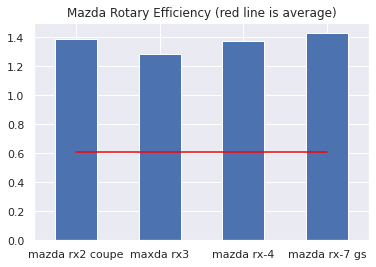

In [7]:
wankels.efficiency.plot(kind='bar')
plt.xticks(np.arange(4),wankels.car_name)
pd.Series([merged['efficiency'].mean() for i in range(len(wankels))]).plot(kind='line',color='red')
plt.title('Mazda Rotary Efficiency (red line is average)');

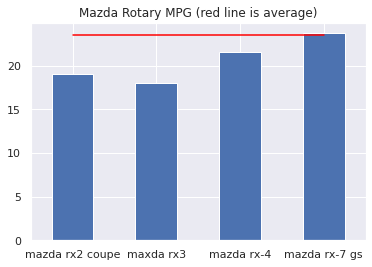

In [8]:
wankels.mpg.plot(kind='bar')
plt.xticks(np.arange(4),wankels.car_name)
pd.Series([merged['mpg'].mean() for i in range(len(wankels))]).plot(kind='line',color='red')
plt.title('Mazda Rotary MPG (red line is average)');

## Diesels

In [9]:
diesels = merged[merged.car_name.str.contains('diesel')]
diesels

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,car_name,efficiency,load,bore_size,grunt
244,43.1,4,90.0,48.0,1985.0,21.5,78,2,volkswagen rabbit custom diesel,0.533333,0.045340,22.500000,576.000000
325,44.3,4,90.0,48.0,2085.0,21.7,80,2,vw rabbit c (diesel),0.533333,0.043165,22.500000,576.000000
326,43.4,4,90.0,48.0,2335.0,23.7,80,2,vw dasher (diesel),0.533333,0.038544,22.500000,576.000000
327,36.4,5,121.0,67.0,2950.0,19.9,80,2,audi 5000s (diesel),0.553719,0.041017,24.200000,897.800000
358,28.1,4,141.0,80.0,3230.0,20.4,81,2,peugeot 505s turbo diesel,0.567376,0.043653,35.250000,1600.000000
359,30.7,6,145.0,76.0,3160.0,19.6,81,2,volvo diesel,0.524138,0.045886,24.166667,962.666667
386,38.0,6,262.0,85.0,3015.0,17.0,82,1,oldsmobile cutlass ciera (diesel),0.324427,0.086899,43.666667,1204.166667


All of the diesels get higher than average MPG

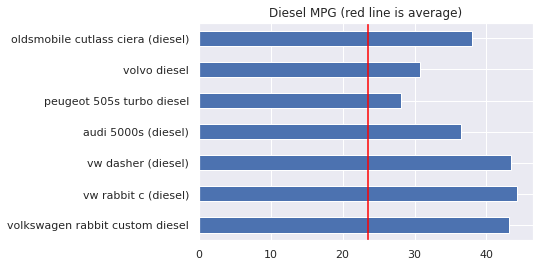

In [10]:
diesels.mpg.plot(kind='barh')
plt.yticks(np.arange(len(diesels)),diesels.car_name)
plt.axvline(merged.mpg.mean(),color='red')
plt.title('Diesel MPG (red line is average)');

# Interesting

In [11]:
merged.iloc[np.where((merged.mpg>35) & (merged.displacement > 250))]

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,car_name,efficiency,load,bore_size,grunt
386,38.0,6,262.0,85.0,3015.0,17.0,82,1,oldsmobile cutlass ciera (diesel),0.324427,0.086899,43.666667,1204.166667


This is an interesting engine. In fact, [these cars are rumored to be the reason why diesel cars are so unpopular in North America](https://www.autotrader.com/car-news/when-diesel-was-dreadful-oldsmobile-diesels-259997). [Here is a more technical write-up](https://www.dieselworldmag.com/diesel-engines/oldsmobile-350-v8)

<hr>

Big lazy engines in big heavy cars don't have to have poor MPG!

In [12]:
merged.iloc[np.where((merged.mpg>20) & (merged.displacement > 340))]

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,car_name,efficiency,load,bore_size,grunt
298,23.0,8,350.0,125.0,3900.0,17.4,79,1,cadillac eldorado,0.357143,0.089744,43.75,1953.125
363,26.6,8,350.0,105.0,3725.0,19.0,81,1,oldsmobile cutlass ls,0.300000,0.093960,43.75,1378.125


But some still do

In [13]:
merged[merged.load>0.14]

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,car_name,efficiency,load,bore_size,grunt
13,14.0,8,455.0,225.0,3086.0,10.0,70,1,buick estate wagon (sw),0.494505,0.14744,56.875,6328.125


Big car, big engine, terrible MPG.. That weight is way off

In [14]:
merged.at[13,'weight'] = 5000
merged['load']  = merged.displacement / merged.weight

## What vehicles have the Highest MPG?

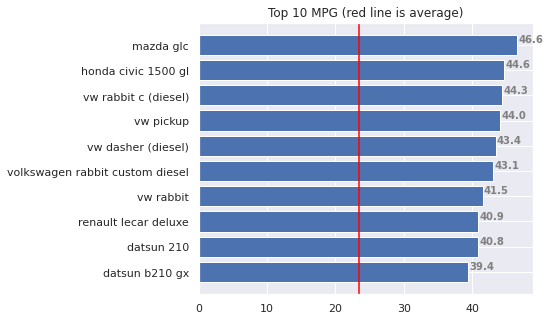

In [15]:
top_mpg = merged.sort_values('mpg').tail(10)

fig, ax = plt.subplots(figsize = (6,5))
ax.barh(top_mpg.car_name,top_mpg.mpg)
for i in ax.patches:
    plt.text(i.get_width()+0.2, i.get_y()+0.5,
             str(round((i.get_width()), 2)),
             fontsize = 10, fontweight ='bold',
             color ='grey')
ax.set_title('Top 10 MPG (red line is average)')
plt.axvline(merged.mpg.mean(),color='red')
plt.show();

In more detail:

In [16]:
merged.sort_values('mpg',ascending=False).head(10)

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,car_name,efficiency,load,bore_size,grunt
322,46.6,4,86.0,65.0,2110.0,17.9,80,3,mazda glc,0.755814,0.040758,21.50,1056.2500
329,44.6,4,91.0,67.0,1850.0,13.8,80,3,honda civic 1500 gl,0.736264,0.049189,22.75,1122.2500
325,44.3,4,90.0,48.0,2085.0,21.7,80,2,vw rabbit c (diesel),0.533333,0.043165,22.50,576.0000
393,44.0,4,97.0,52.0,2130.0,24.6,82,2,vw pickup,0.536082,0.045540,24.25,676.0000
326,43.4,4,90.0,48.0,2335.0,23.7,80,2,vw dasher (diesel),0.533333,0.038544,22.50,576.0000
244,43.1,4,90.0,48.0,1985.0,21.5,78,2,volkswagen rabbit custom diesel,0.533333,0.045340,22.50,576.0000
309,41.5,4,98.0,76.0,2144.0,14.7,80,2,vw rabbit,0.775510,0.045709,24.50,1444.0000
330,40.9,4,85.0,53.5,1835.0,17.3,80,2,renault lecar deluxe,0.629412,0.046322,21.25,715.5625
324,40.8,4,85.0,65.0,2110.0,19.2,80,3,datsun 210,0.764706,0.040284,21.25,1056.2500
247,39.4,4,85.0,70.0,2070.0,18.6,78,3,datsun b210 gx,0.823529,0.041063,21.25,1225.0000


## What vehicles have the lowest MPG?

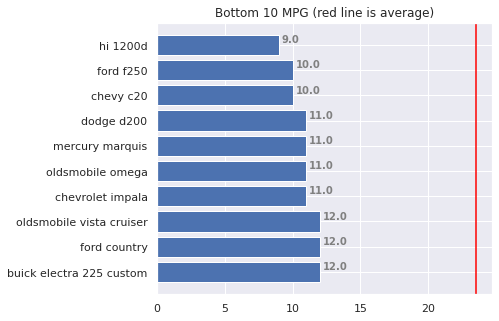

In [17]:
low_mpg = merged.sort_values('mpg', ascending=False).tail(10)

fig, ax = plt.subplots(figsize = (6,5))
ax.barh(low_mpg.car_name,low_mpg.mpg)
for i in ax.patches:
    plt.text(i.get_width()+0.2, i.get_y()+0.5,
             str(round((i.get_width()), 2)),
             fontsize = 10, fontweight ='bold',
             color ='grey')
ax.set_title('Bottom 10 MPG (red line is average)')
plt.axvline(merged.mpg.mean(),color='red')
plt.show();

In more detail:

In [18]:
merged.sort_values('mpg').head(10)

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,car_name,efficiency,load,bore_size,grunt
28,9.0,8,304.0,193.0,4732.0,18.5,70,1,hi 1200d,0.634868,0.064243,38.000,4656.125
26,10.0,8,307.0,200.0,4376.0,15.0,70,1,chevy c20,0.651466,0.070155,38.375,5000.000
25,10.0,8,360.0,215.0,4615.0,14.0,70,1,ford f250,0.597222,0.078007,45.000,5778.125
27,11.0,8,318.0,210.0,4382.0,13.5,70,1,dodge d200,0.660377,0.072570,39.750,5512.500
103,11.0,8,400.0,150.0,4997.0,14.0,73,1,chevrolet impala,0.375000,0.080048,50.000,2812.500
67,11.0,8,429.0,208.0,4633.0,11.0,72,1,mercury marquis,0.484848,0.092597,53.625,5408.000
124,11.0,8,350.0,180.0,3664.0,11.0,73,1,oldsmobile omega,0.514286,0.095524,43.750,4050.000
42,12.0,8,383.0,180.0,4955.0,11.5,71,1,dodge monaco (sw),0.469974,0.077296,47.875,4050.000
95,12.0,8,455.0,225.0,4951.0,11.0,73,1,buick electra 225 custom,0.494505,0.091901,56.875,6328.125
90,12.0,8,429.0,198.0,4952.0,11.5,73,1,mercury marquis brougham,0.461538,0.086632,53.625,4900.500


## Some stats

In [19]:
print(f'''Mean MPG: {y.mean():.2f}
Mean Weight: {merged.weight.mean():.2f}
Mean Horsepower: {merged.horsepower.mean():.2f}''')

for col in merged.columns[9:]:
    print(f'{col} mean: {merged[col].mean():.2f}')

Mean MPG: 23.51
Mean Weight: 2975.41
Mean Horsepower: 104.12
efficiency mean: 0.61
load mean: 0.06
bore_size mean: 33.36
grunt mean: 2060.50


Check Correlation

In [20]:
merged.corrwith(y).sort_values()

weight         -0.832707
displacement   -0.804456
horsepower     -0.777897
cylinders      -0.776090
bore_size      -0.773403
load           -0.724271
grunt          -0.644081
acceleration    0.420414
efficiency      0.509309
origin          0.563833
model_year      0.580091
mpg             1.000000
dtype: float64

<hr>
Math says to use weight, displacement, horsepower, cylinders...

While I agree that these are the most important features, there's more to it than just these numbers. Like how a stew is not just a sum of its ingredients.

I'll test both

In [21]:
merged.columns

Index(['mpg', 'cylinders', 'displacement', 'horsepower', 'weight',
       'acceleration', 'model_year', 'origin', 'car_name', 'efficiency',
       'load', 'bore_size', 'grunt'],
      dtype='object')

In [22]:
y.to_csv('data/y.csv',index=False)

merged[[\
    'horsepower',
    'bore_size',
    'grunt',
    'load',
   ]].to_csv('data/X_engineered.csv',index=False)

merged[[\
    'horsepower',
    'weight',
    'displacement',
    'cylinders',
   ]].to_csv('data/X_straight.csv',index=False)

[Modeling](model.ipynb)